In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds_n = None, bounds_z = None, Nbins = 100, sigma = .3):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.sigma = sigma
        self.x = np.linspace(-1, 1, Nbins)
        
        self.z_sampler = swyft.RectBoundSampler(
            [stats.uniform(-.1, .2),
             stats.uniform(-.1, .2),
             stats.uniform(-.1, .2)
            ],
            bounds = bounds_z
        )
        
        self.n_sampler = swyft.RectBoundSampler(
            [stats.norm(0, np.ones(Nbins)*self.sigma),
            ],
            bounds = bounds_n
        )

    def calc_m(self, a, b, c):
        return 2*(a+b*self.x+c*self.x**2)
        
    def build(self, graph):
        n = graph.node("n", lambda: self.n_sampler())
        #n = graph.node("n", lambda: np.random.randn(self.Nbins)*self.sigma)
        z = graph.node("z", self.z_sampler)
        a, b, c = graph.node(['a', 'b', 'c'], lambda z: z, z)        
        m = graph.node("m", self.calc_m, a, b, c)
        d = graph.node("d", lambda m, n: m+n, m, n)
            

In [4]:
bounds_n = None
bounds_z = None

In [5]:
NBINS = 1000
sim = Simulator(Nbins = NBINS)
obs = sim.sample()

In [6]:
sim = Simulator(Nbins = NBINS, bounds_n = bounds_n, bounds_z = bounds_z)

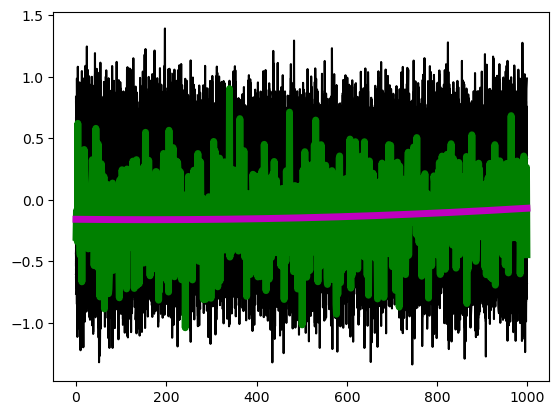

In [12]:
for _ in range(100):
    sample = sim.sample()
    plt.plot(sample['d'], 'k')
    #plt.plot(sample['m'], 'r')
plt.plot(obs['d'], 'g', lw = 5)
plt.plot(obs['m'], 'm', lw = 5)

In [13]:
samples = sim.sample(10_000)
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], num_workers = 0, batch_size = 64)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.lin_1 = torch.nn.Linear(NBINS, 3)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 3, num_params = 3, varnames = 'z')

        #self.conv1d_1 = torch.nn.Conv1d(1, 1, 5, padding = 2)
        #self.lin_2 = torch.nn.Linear(NBINS, 32)
        self.logratios2 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = NBINS, varnames = 'n',
                                                       hidden_features = 32, dropout = 0.0, num_blocks = 3)
        self.logratios3 = swyft.LogRatioEstimator_1dim_Gaussian(num_params = NBINS, varnames = 'n')
        self.optimizer_init = swyft.AdamOptimizerInit(lr = 1e-2, lrs_factor = 0.3, lrs_patience = 2)

    def forward(self, A, B):
        # Estimate parameters of parabola
        f = self.lin_1(A['d'])  # data summaries
        logratios1 = self.logratios1(f, B['z'])
        
        # Estimate
        #n = self.conv1d_1(A['d'].unsqueeze(-2)).squeeze(-2)  # data summaries
        #n = self.lin_2(A['d'])
        d = A['d'].unsqueeze(-1)#[...,:1]
        n = B['n']#[...,:1]
        #print(d.shape, n.shape)
        #print(d)
        #print(n)
        #qwerty
        #A_d, B_n = swyft.equalize_tensors(A['d'], B['n'])
        #logratios2 = self.logratios2(d, n)
        
        logratios3 = self.logratios3(A['d'], B['n'])
 
        return logratios1, logratios3

network = Network()

In [15]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', devices=1, max_epochs = 1, precision = 32)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [16]:
trainer.fit(network, dm)


  | Name       | Type                            | Params
---------------------------------------------------------------
0 | lin_1      | Linear                          | 3.0 K 
1 | logratios1 | LogRatioEstimator_1dim          | 52.6 K
2 | logratios2 | LogRatioEstimator_1dim          | 6.8 M 
3 | logratios3 | LogRatioEstimator_1dim_Gaussian | 0     
---------------------------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.618    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [17]:
prior_samples = sim.sample(10_000, targets = ['z', 'n'])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
predictions = trainer.infer(network, obs, prior_samples)

Predicting: 125it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


(-0.1, 0.1)

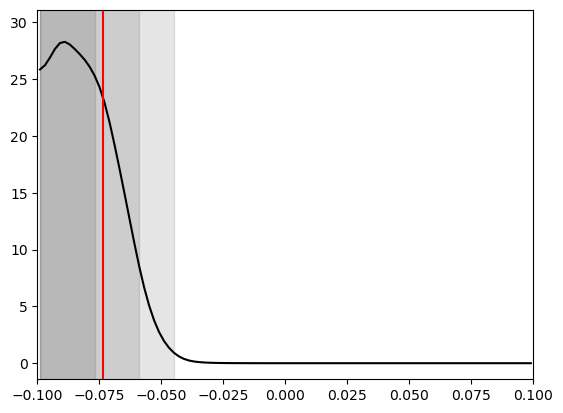

In [19]:
ax = plt.gca()
i = 0
swyft.plot_1d(predictions, "z[%i]"%i, ax = ax, bins=100, smooth = 2)
ax.axvline(obs['z'][i], color='r')
plt.xlim([-0.1, 0.1])

(-0.1, 0.1)

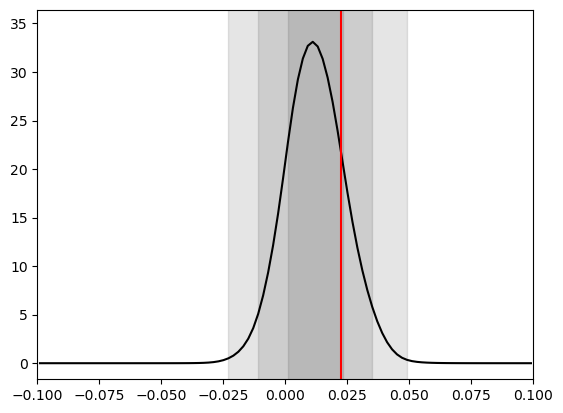

In [20]:
ax = plt.gca()
i = 1
swyft.plot_1d(predictions, "z[%i]"%i, ax = ax, bins=100, smooth = 2)
ax.axvline(obs['z'][i], color='r')
plt.xlim([-0.1, 0.1])

In [31]:
params = predictions[1].params
logratios = predictions[1].logratios

torch.Size([10000, 1000, 1])